In [1]:
from transformers import BertModel
from transformers import BertTokenizer
import torch

bert = BertModel.from_pretrained("bert-base-uncased")

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
# input text

text = "Prepend the token to the start of the sequence"
sent_id = tokenizer.encode(text,
                          #  add [CLS] and [SEP] tokens
                          add_special_tokens=True,
                          # specify maximum length for the sequences
                          max_length=15,
                          truncation=True,
                          # add pad tokens to the right side of the sequence
                          pad_to_max_length='right')

# print integer sequence
print("Integer Sequence: {}".format(sent_id))
# convert integers back to text
print("Tokenized Text:",tokenizer.convert_ids_to_tokens(sent_id))

Integer Sequence: [101, 17463, 10497, 1996, 19204, 2000, 1996, 2707, 1997, 1996, 5537, 102, 0, 0, 0]
Tokenized Text: ['[CLS]', 'prep', '##end', 'the', 'token', 'to', 'the', 'start', 'of', 'the', 'sequence', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


C:\Users\amber\anaconda3\envs\transformer\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [4]:
decoded = tokenizer.decode(sent_id)
print("Decoded String: {}".format(decoded))

att_mask = [int(tok > 0) for tok in sent_id]
print("Attention Mask:",att_mask)

Decoded String: [CLS] prepend the token to the start of the sequence [SEP] [PAD] [PAD] [PAD]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]


In [5]:
# convert lists to tensors
sent_id = torch.tensor(sent_id)
att_mask = torch.tensor(att_mask)

# reshaping tensor in form of (batch,text length)
sent_id = sent_id.unsqueeze(0)
att_mask = att_mask.unsqueeze(0)
sent_id

tensor([[  101, 17463, 10497,  1996, 19204,  2000,  1996,  2707,  1997,  1996,
          5537,   102,     0,     0,     0]])

In [6]:
outputs = bert(sent_id,attention_mask = att_mask)

In [7]:
#unpack the ouput of bert model
# hidden states at each timestep
all_hidden_states = outputs[0]
# hidden states at first timestep ([CLS] token)
cls_hidden_state = outputs[1]
print("Shape of last hidden states:",all_hidden_states.shape)
print("Shape of CLS hidden state:",cls_hidden_state.shape)

Shape of last hidden states: torch.Size([1, 15, 768])
Shape of CLS hidden state: torch.Size([1, 768])


## IMDB Sentiment Classification

This is a dataset for binary sentiment classification, where each example contains a movie review along with its positive or negative sentiment label.
bert-base-uncased is one of the pre-trained models from the BERT (Bidirectional Encoder Representations from Transformers) family of models developed by Google AI. It is a widely used variant of BERT and has been pre-trained on a massive amount of text data, including a mixture of books, articles, and web pages.

Note that different BERT model variants may have different maximum sequence lengths, so be sure to understand which max_length you are working with. Generally, max_length = 512 is the default for BERT models.

In this example we fine-tune ALL the parameters of BERT. Notice in cell 14, we pass model.parameters() to the optimizer, where the model.parameters() call includes all the trainable parameters in the BertForSequenceClassification model, which includes the BERT base model along with the classification head specific to our task.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
import pandas as pd
df = pd.read_csv('IMDB Dataset.csv')
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [11]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

### Load BERT tokenizer and model

In [12]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Inspect model config
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [14]:
# Inspect the maximum sequence length
tokenizer.model_max_length

512

## Tokenize sentiments
Converts the 'review' column to a list.
Tokenizes and encodes the reviews in batches.
Adds the input_ids and attention_mask as new columns in the DataFrame.
Converts the 'sentiment' column to a binary format.

In [15]:
# Batch Tokenization and Encoding Function:
def batch_tokenize_and_encode(texts, max_length = 256):
    encoding = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_attention_mask=True,
        return_tensors='np'
    )
    return encoding['input_ids'], encoding['attention_mask']

# Sentiment Conversion Function:
def sentiment_to_bool(sentiment):
    return 1 if sentiment == 'positive' else 0


# <<=======================================>>
# Main Processing Function:
def process_dataframe(df):
    reviews = df['review'].tolist()
    input_ids, attention_masks = batch_tokenize_and_encode(reviews)
    df['input_ids'] = list(input_ids)
    df['attention_mask'] = list(attention_masks)
    df['sentiment_bool'] = df['sentiment'].apply(sentiment_to_bool)
    return df
    
tqdm.pandas()
df = process_dataframe(df)
df.head(10)    

,review,sentiment,input_ids,attention_mask,sentiment_bool
0,One of the other reviewers has mentioned that ...,positive,"[101, 2028, 1997, 1996, 2060, 15814, 2038, 385...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
1,A wonderful little production. <br /><br />The...,positive,"[101, 1037, 6919, 2210, 2537, 1012, 1026, 7987...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,I thought this was a wonderful way to spend ti...,positive,"[101, 1045, 2245, 2023, 2001, 1037, 6919, 2126...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,Basically there's a family where a little boy ...,negative,"[101, 10468, 2045, 1005, 1055, 1037, 2155, 207...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[101, 9004, 3334, 4717, 7416, 1005, 1055, 1000...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
5,"Probably my all-time favorite movie, a story o...",positive,"[101, 2763, 2026, 2035, 1011, 2051, 5440, 3185...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
6,I sure would like to see a resurrection of a u...,positive,"[101, 1045, 2469, 2052, 2066, 2000, 2156, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
7,"This show was an amazing, fresh & innovative i...",negative,"[101, 2023, 2265, 2001, 2019, 6429, 1010, 4840...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
8,Encouraged by the positive comments about this...,negative,"[101, 6628, 2011, 1996, 3893, 7928, 2055, 2023...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
9,If you like original gut wrenching laughter yo...,positive,"[101, 2065, 2017, 2066, 2434, 9535, 16255, 845...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


### Train / Validate / Test split

In [16]:
train_df, temp_df = train_test_split(df,test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

### Convert data to PyTorch tensors

In [17]:
import numpy as np
def convert_to_tensors(df):
    input_ids = torch.tensor(np.array(df['input_ids'].tolist()))
    attention_masks = torch.tensor(np.array(df['attention_mask'].tolist()))
    labels = torch.tensor(df['sentiment_bool'].values)
    return input_ids, attention_masks, labels

train_input_ids, train_attention_masks, train_labels = convert_to_tensors(train_df)
val_input_ids, val_attention_masks, val_labels = convert_to_tensors(val_df)
test_input_ids, test_attention_masks, test_labels = convert_to_tensors(test_df)

### Create DataLoader for efficient batch processing

When a DataLoader is created with shuffle=True, it shuffles the data once at the beginning when the DataLoader is created for that epoch. So, within a single epoch, the order of batches remains the same, but when a new epoch is started, the data is shuffled again, leading to a different order of examples for each epoch. This is a common practice in training deep learning models to ensure that the model doesn't memorize the order of examples and generalizes well across different batches and epochs.

In [18]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [19]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Define optimizer and loss function

In [20]:
from transformers import AdamW

# store during forward passes. 
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 2, 
                                                      output_attentions = False, 
                                                      output_hidden_states = False)

model = model.to(device)

# Define optimizer and scheduler using PyTorch's AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\amber\anaconda3\envs\transformer\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Model training and validation

In [25]:
# Training function with tqdm
# Training function
def train():
    model.train()
    total_loss, total_correct = 0, 0
    for inputs, attention_mask, labels in train_loader:
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / len(train_loader.dataset)
    return avg_loss, accuracy


# Evaluation function with tqdm
def evaluate():
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for inputs, attention_mask, labels in val_loader:
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            total_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
    avg_loss = total_loss / len(val_loader)
    accuracy = total_correct / len(val_loader.dataset)
    return avg_loss, accuracy
   

In [26]:
# Training loop
epochs = 5
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in tqdm(range(epochs), desc="Epoch"):
    print(f'\n....... Epoch {epoch + 1} / {epochs} .......')
    train_loss, train_acc = train()
    valid_loss, val_acc = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(val_acc)

    print(f'\nTraining Loss: {train_loss:.3f}, Training Accuracy: {train_acc:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}, Validation Accuracy: {val_acc:.3f}')

print("\nTraining complete!")

Epoch:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]


....... Epoch 1 / 5 .......


Epoch:  20%|██████████████▏                                                        | 1/5 [1:15:29<5:01:58, 4529.51s/it]


Training Loss: 0.216, Training Accuracy: 0.916
Validation Loss: 0.213, Validation Accuracy: 0.917

....... Epoch 2 / 5 .......


Epoch:  40%|████████████████████████████▍                                          | 2/5 [3:39:43<5:47:46, 6955.49s/it]


Training Loss: 0.123, Training Accuracy: 0.957
Validation Loss: 0.200, Validation Accuracy: 0.927

....... Epoch 3 / 5 .......


Epoch:  60%|██████████████████████████████████████████▌                            | 3/5 [5:12:01<3:30:16, 6308.25s/it]


Training Loss: 0.062, Training Accuracy: 0.980
Validation Loss: 0.247, Validation Accuracy: 0.929

....... Epoch 4 / 5 .......


Epoch:  80%|████████████████████████████████████████████████████████▊              | 4/5 [5:58:44<1:22:04, 4924.54s/it]


Training Loss: 0.040, Training Accuracy: 0.987
Validation Loss: 0.277, Validation Accuracy: 0.926

....... Epoch 5 / 5 .......


Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [6:45:27<00:00, 4865.57s/it]


Training Loss: 0.030, Training Accuracy: 0.990
Validation Loss: 0.309, Validation Accuracy: 0.924

Training complete!


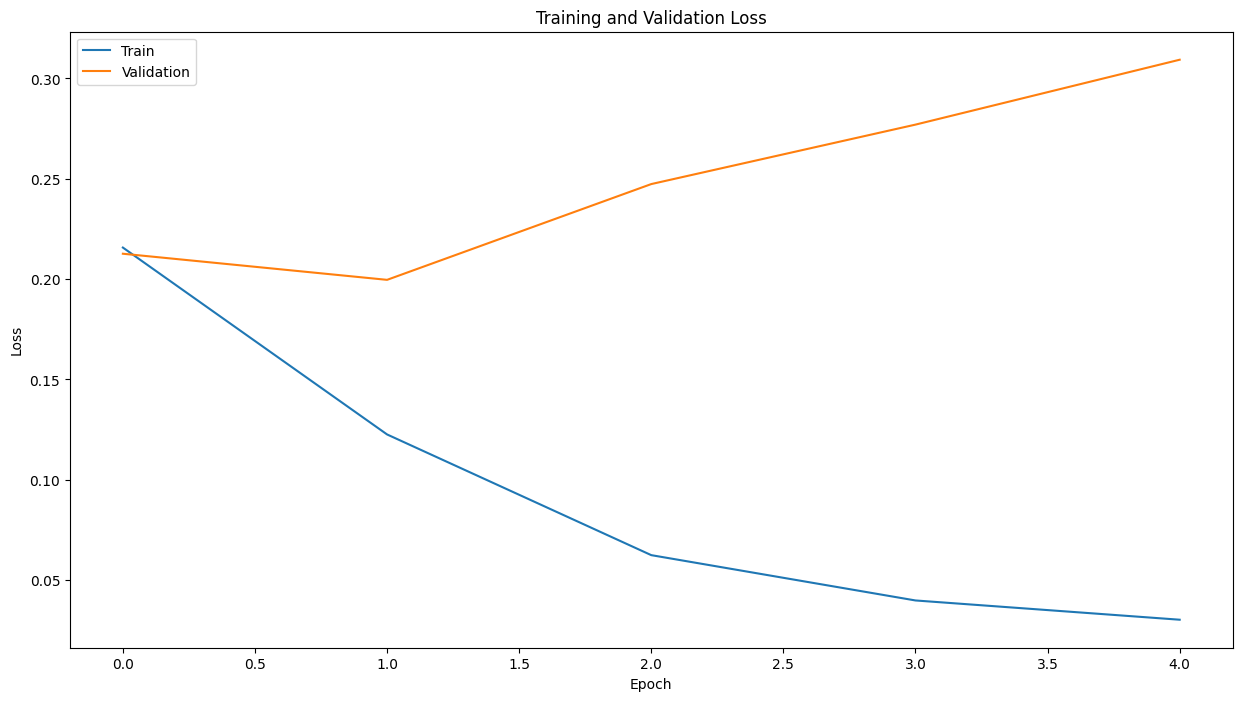

In [28]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Validation")
plt.legend()
plt.show()

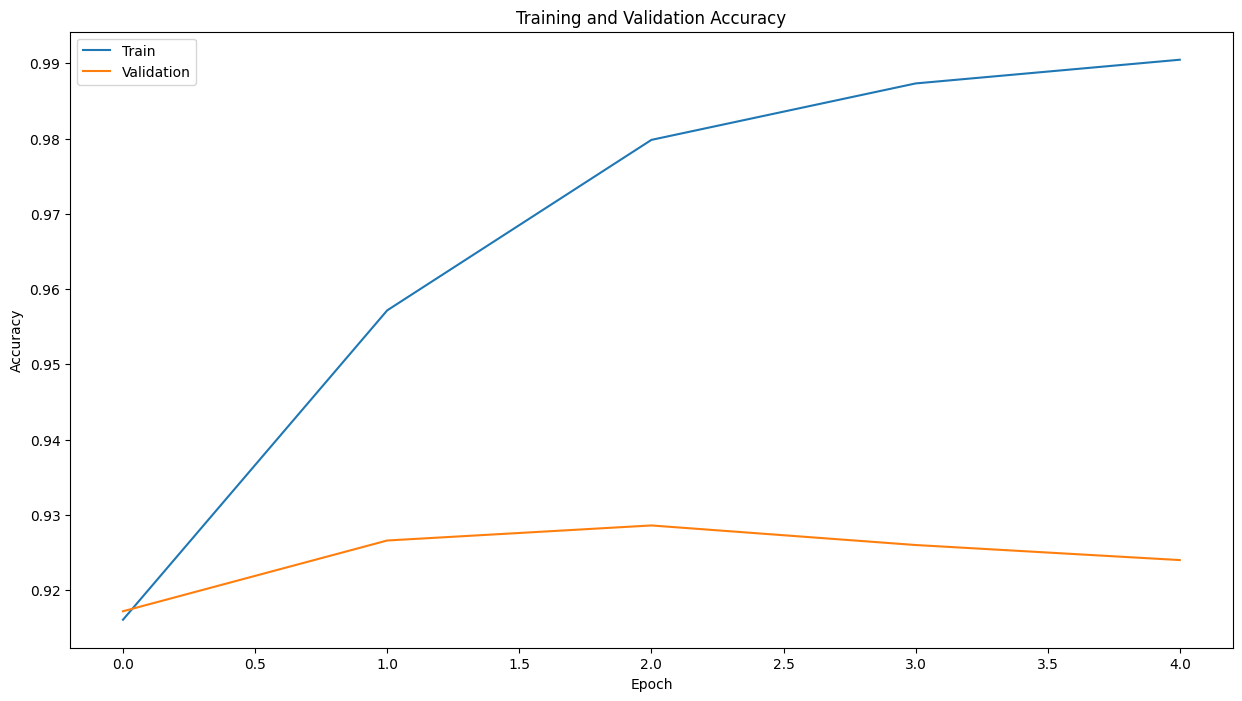

In [29]:
# Plot the training and validation accuracy
plt.figure(figsize=(15, 8))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies, label="Train")
plt.plot(valid_accuracies, label="Validation")
plt.legend()
plt.show()

In [33]:
import torch
from transformers import BertTokenizer, BertForNextSentencePrediction

# load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define the model architecture and load saved weights
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)
model.load_state_dict(torch.load('saved_weights.pt',map_location=torch.device('cpu')))

# Ensure the model is in evaluation mode
model.eval()

def predict_review(text):
    # Preprocess the input text
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = 128,
        truncation=True,
        padding='max_length',
        return_tensors='pt')

    # Get the model's predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

     # Interpret the predictions
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return 'Positive' if predicted_class.item() == 1 else 'Negative'

# Example usage
review_text = "This is not a fantastic movie!"
prediction = predict_review(review_text)
print(f"Review: {review_text}\nSentiment: {prediction}")        
    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Review: This is not a fantastic movie!
Sentiment: Negative
